## Warehouse 환경

In [1]:
import os
import numpy as np
from crewai import Agent, Task, Crew
from environment import Environment
import configs
import pickle

os.environ["OPENAI_API_KEY"] = ""

class Experiment:
    def __init__(self, startx, starty, goalx, goaly, scaleX=None, scaleY=None, bucket=None, distance=None, map_name=None):
        self.startx = startx
        self.starty = starty
        self.goalx = goalx
        self.goaly = goaly
        self.scaleX = scaleX
        self.scaleY = scaleY
        self.bucket = bucket
        self.distance = distance
        self.map_name = map_name

    def __str__(self):
        return f"Experiment(start=({self.startx}, {self.starty}), goal=({self.goalx}, {self.goaly}), map={self.map_name})"

def load_scenarios(filename):
    experiments = []
    with open(filename, 'r') as file:
        first_line = file.readline().strip()
        if first_line.startswith("version"):
            _, version = first_line.split()
            version = float(version)
        else:
            version = 0.0
            file.seek(0)

        if version == 0.0:
            for line in file:
                bucket, map_name, startx, starty, goalx, goaly, distance = line.split()
                experiments.append(Experiment(int(startx), int(starty), int(goalx), int(goaly),
                                              bucket=int(bucket), distance=float(distance), map_name=map_name))
        elif version == 1.0:
            for line in file:
                bucket, map_name, scaleX, scaleY, startx, starty, goalx, goaly, distance = line.split()
                experiments.append(Experiment(int(startx), int(starty), int(goalx), int(goaly), int(scaleX), int(scaleY),
                                              bucket=int(bucket), distance=float(distance), map_name=map_name))
        else:
            raise ValueError("Unsupported version number")

    return experiments

filename = 'C:\\Users\\Owner\\MAPF\\scen-random\\warehouse-10-20-10-2-1-random-1.scen'
experiments = load_scenarios(filename)
for exp in experiments:
    print(exp)

Experiment(start=(143, 57), goal=(10, 16), map=warehouse-10-20-10-2-1.map)
Experiment(start=(134, 28), goal=(91, 6), map=warehouse-10-20-10-2-1.map)
Experiment(start=(66, 7), goal=(36, 56), map=warehouse-10-20-10-2-1.map)
Experiment(start=(25, 49), goal=(48, 49), map=warehouse-10-20-10-2-1.map)
Experiment(start=(104, 1), goal=(112, 13), map=warehouse-10-20-10-2-1.map)
Experiment(start=(72, 46), goal=(110, 58), map=warehouse-10-20-10-2-1.map)
Experiment(start=(155, 1), goal=(154, 41), map=warehouse-10-20-10-2-1.map)
Experiment(start=(19, 43), goal=(17, 10), map=warehouse-10-20-10-2-1.map)
Experiment(start=(21, 42), goal=(39, 37), map=warehouse-10-20-10-2-1.map)
Experiment(start=(155, 6), goal=(78, 28), map=warehouse-10-20-10-2-1.map)
Experiment(start=(119, 4), goal=(73, 28), map=warehouse-10-20-10-2-1.map)
Experiment(start=(101, 19), goal=(38, 19), map=warehouse-10-20-10-2-1.map)
Experiment(start=(58, 13), goal=(143, 54), map=warehouse-10-20-10-2-1.map)
Experiment(start=(70, 61), goal=(

In [ ]:
#negotiator를 구성하기 위한 union find 알고리즘

def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]

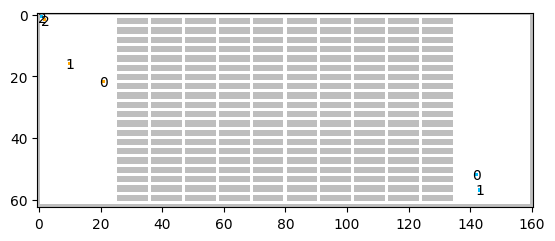

In [4]:
with open('C:\\Users\\Owner\\MAPF\\warehouse-10-20-10-2-1.txt', 'r', encoding='utf-8') as file:
    content = file.read()

content = content.replace('T', '1')
content = content.replace('.', '0')

map_start_index = content.find('map') + len('map')

map_content = content[map_start_index:].strip()

map_lines = [list(line.strip()) for line in map_content.split('\n') if line.strip()]

map_array = np.array(map_lines, dtype=int)

toy = (map_array, np.array([[52, 142], [57, 143], [1, 1]]), np.array([[22, 21], [16, 10], [2, 2]]))

num_agents = len(toy[1])
map_width = len(toy[0][0]) - 1

env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

In [5]:
directiondict = {
    'Stay': 0, 'North': 1, 'South': 2, 'West': 3, 'East': 4, 'Stay.': 0, 'North.': 1, 'South.': 2, 'West.': 3, 'East.': 4 
}

class PathFindingAgents:
  def path_finder(self, agent_number):
    return Agent(
      role='Path finder',
      goal='Start at the start point and reach the end point without crashing into a wall.',
      backstory=f"""You are a veteran adventurer with a great sense of direction.
      You understand which direction you need to move to get from where you are to where you want to go.
      Your agent number is {agent_number}.
      """,
      verbose=True
    )
    
  def negotiator(self):
    return Agent(
      role='Negotiator',
      goal="""Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.""",
      backstory="""You're a veteran overseer, and you've been called in to resolve the deadlock, as each agent is in the other's line of sight.
      """,
      verbose=True,
    )
	
class PathFindingTasks():
  def path_finding(self, agent, x, y, x_finish, y_finish, east, west, north, south, last_action):
    return Task(
      description=(
        f"""
        Your current coordinates are ({x},{y}) and your destination is ({x_finish},{y_finish}).
        East and west in the coordinates correspond to the x axis.
        South and north in the coordinates correspond to the y axis.
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        {east}
        {west}
        {south}
        {north}
        Which direction do you move next?
        {last_action}
        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )
    
  def negotiate(self, agent):
    return Task(
      description=(
        f"""
        Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.
        The planned moves of each agent represent the previous outcomes.
        """
      ),
      expected_output='Direction of the agents',
      agent=agent
    )

agents = PathFindingAgents()
tasks = PathFindingTasks()

agents_set = [agents.path_finder(i) for i in range(num_agents)]
negotiator = agents.negotiator()

In [6]:
#에이전트들의 지난번 액션들
action_list = [[] for _ in range(num_agents)]



> Entering new CrewAgentExecutor chain...


2024-06-11 15:03:14,658 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position (142,10) and my destination (21,40), I need to move towards the west and north. Since there are paths in all directions, I can choose either direction to start. But considering that I am much farther east than my destination, I should prioritize moving west over moving north.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:03:19,265 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates are (143,5) and I need to get to (10,46), I need to head west to decrease my x-coordinate and north to increase my y-coordinate. Both paths are available to me so I can choose either. However, considering the greater difference between my current and desired x-coordinates, it would be more efficient to start moving west first.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Looking at the current coordinates and the destination, I can see that I need to move one unit to the east and one unit to the south. Since I can only move one step at a time, I will first move to the east since it is not blocked.

Final Answer: East

> Finished chain.


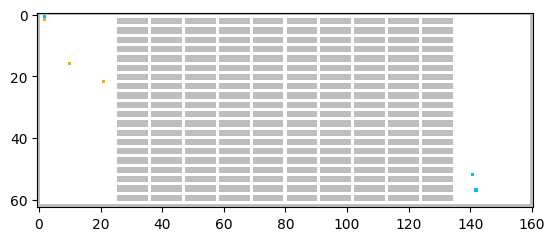

2024-06-11 15:03:23,714 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:03:27,431 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current location and the destination, I need to move west to decrease my x-coordinate and north to increase my y-coordinate. Since I just came from the east, it would be logical to continue west to avoid backtracking.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:03:32,906 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current coordinates (142,5), I need to get to (10,46). I came from the east, so I definitely need to head to the west to decrease my x-axis value. However, my y-axis value is also significantly lower than my target destination. Given the choice between moving north or south, moving north would increase my y-axis value. This will bring me closer to my destination. Therefore, moving west or north would be my best options.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Based on my current coordinates and my destination, I need to move south to reach my goal. Since there is a path available to the south, this is the correct direction to proceed.

Final Answer: South

> Finished chain.


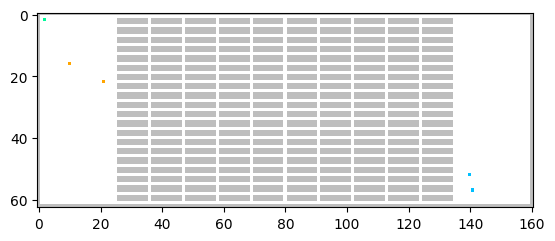

2024-06-11 15:03:36,207 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:03:43,593 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


From my current coordinates (140,10), I need to reach my destination at (21,40). Given that east and west movements reflect on the x-axis, and south and north movements affect the y-axis, I need to prioritize reducing my x-coordinate while increasing my y-coordinate. Since I came from the east, it means I should avoid moving in the same direction to prevent increasing the x-coordinate. Therefore, the best direction to move would be to the west to decrease my x-coordinate, or to the north to increase my y-coordinate. Since there are no obstacles in any direction according to the current information, I choose the direction that will get me closer to my goal.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:03:48,025 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current coordinates are (141,5) and the destination is (10,46), I need to move towards the west to decrease my x-coordinate and towards the north to increase my y-coordinate. Both paths are available. However, since I came from the east, to avoid backtracking, my next move should be towards the west to start closing the gap in the x-coordinate.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current coordinates are the same as my destination coordinates, I don't need to move. 

Final Answer: Stay

> Finished chain.


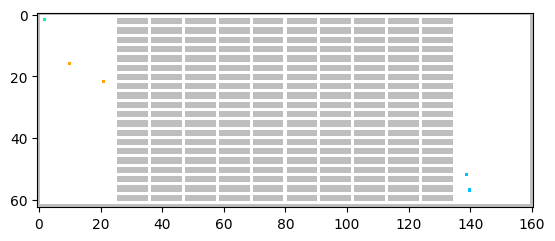

2024-06-11 15:03:50,454 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:03:54,725 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


To reach my destination from my current position (139,10) to (21,40), I need to move west to decrease my x-coordinate and north to increase my y-coordinate. Since I came from east, it would be logical to continue my path westward to avoid retracing my steps and make progress towards my destination.

Final Answer: West.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:04:00,175 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location is (140,5) and my destination is (10,46), it is clear that I need to move west (to decrease my x-coordinate from 140 to 10) and north (to increase my y-coordinate from 5 to 46). Given that I can only make one move at a time and I came from the east, the optimal direction would be west to start closing the gap in the x-axis. 

Final Answer: West.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current location is the same as my destination, there is no need for me to move.

Final Answer: Stay.

> Finished chain.


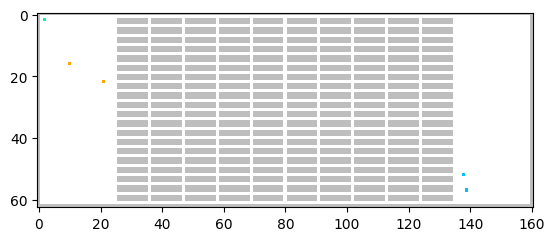

2024-06-11 15:04:02,916 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:04:10,350 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (138,10) and my destination (21,40), I need to move west and north. However, since I just came from the east, moving west would bring me closer to the x-coordinate of my destination. My decision is based on the information that there is a path available in all directions.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:04:13,987 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering that my current position is (139,5) and my goal is to reach the coordinates (10,46), I need to move west to reduce my x-coordinate and north to increase my y-coordinate. Since I came from the east, going west would be the strategic move to avoid backtracking. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I am already at my destination, there is no need for me to move. 

Final Answer: Stay.

> Finished chain.


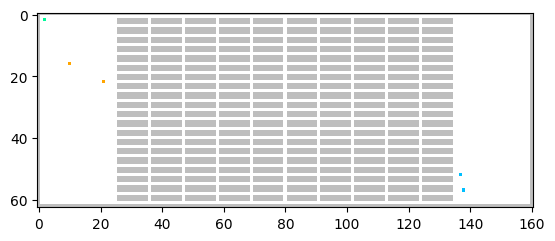

2024-06-11 15:04:16,471 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:04:20,672 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current position (137,10) and my destination (21,40), I need to move both west and north. Since I just came from the east, moving west would take me closer to my destination along the x axis. Therefore, the optimal direction to move would be west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:04:25,246 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering that my current position is (138,5) and I need to reach (10,46), I must move towards the west to decrease my x-coordinate and towards the north to increase my y-coordinate. Since I came from the east, I should avoid backtracking. Therefore, I should move towards the west or north. However, since the x-coordinate difference is larger than the y-coordinate difference, I should prioritize moving west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I am already at the destination point, I do not need to move anymore.

Final Answer: Stay.

> Finished chain.


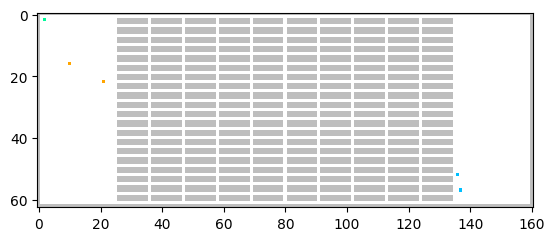

2024-06-11 15:04:27,752 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:04:34,620 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current location (136,10), I need to head west (decrease on the x-axis) and north (increase on the y-axis) to reach my destination (21,40). Since I just came from the east, I will avoid backtracking. I also have open paths to the west, north, and south. Although going south would take me further from my destination, going north or west would bring me closer. Considering I am further from my destination on the x-axis than on the y-axis, I should prioritize moving west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:04:39,383 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given that my current location is (137,5) and I need to get to (10,46), I need to move west to decrease my x-coordinate and north to increase my y-coordinate. However, since I came from the east, to avoid backtracking, my best option would be to first head north which also brings me closer to my destination's y-coordinate.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current location is the same as my destination, there is no need for me to move.

Final Answer: Stay.

> Finished chain.


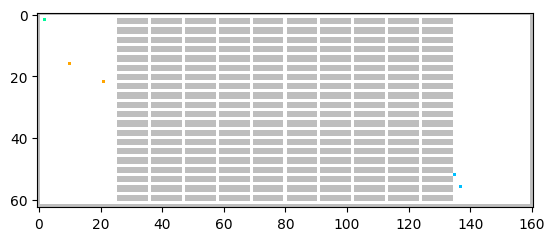

2024-06-11 15:04:42,019 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:04:45,926 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates are (135,10) and my destination is (21,40), I need to move west to decrease my x coordinate and north to increase my y coordinate. I came from the east, but there's no information suggesting that I can't go back in that direction. Therefore, I should move to the west to get closer to my destination.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:04:50,357 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current position is (137,6) and my destination is (10,46), it seems like I need to move West to decrease my x-coordinate and North to increase my y-coordinate. I came from the South, and there are paths available in all directions. But, considering the coordinates, I should move West to get closer to my destination.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current location is the same as my destination, it means I am already at my end point. Therefore, there is no need to move in any direction.

Final Answer: Stay

> Finished chain.


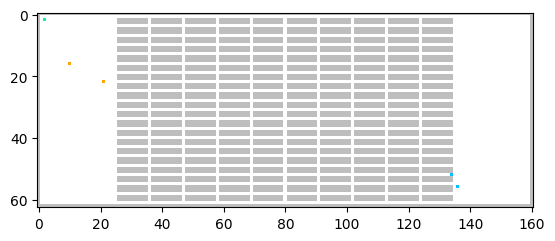

2024-06-11 15:04:54,112 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:05:01,461 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current position and considering the available paths, I need to move towards the destination which is located at (21,40). Since I am currently at (134,10), it means I need to go west to decrease my x-coordinate and reach closer to the x-coordinate of the destination. Also, since the paths to the south and north are blocked, my only logical option is to go west. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:05:06,706 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the current coordinates (136,6) and the destination coordinates (10,46), I need to move in the direction that will bring me closer to the destination. Since I just came from the east, I should not go back in the same direction. Therefore, I should move west to decrease the x-coordinate and north to increase the y-coordinate. Considering that I can only move in one direction at a time, let's prioritize moving towards the x-coordinate of the destination first. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I am already at my destination, I don't need to move anywhere. 

Final Answer: Stay

> Finished chain.


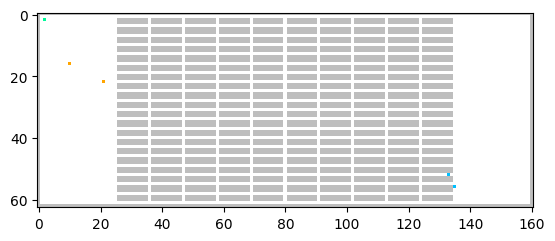

2024-06-11 15:05:10,120 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:05:16,967 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering our current coordinates (133,10) and our destination (21,40), it's clear that we need to move west to decrease our x-coordinate and north to increase our y-coordinate. However, our movement to the north is currently blocked by a wall. Given that we can only make one move at a time, and our south and north paths are blocked, the best option would be to move west as it's the only possible direction towards our destination. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:05:20,491 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since the destination (10,46) is to the west and north of my current position (135,6), and considering that my west is blocked by a wall and I just came from east, I should head towards north to eventually reach the destination.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current coordinates are the same as my destination, there is no need for me to move.

Final Answer: Stay

> Finished chain.


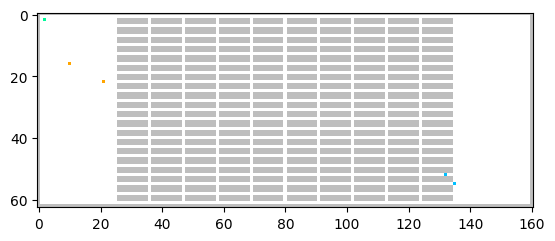

2024-06-11 15:05:22,985 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:05:27,370 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position is (132,10) and my destination is (21,40), I need to move west and north to reach my destination. As for the immediate next step, since my path to the south and north is blocked by a wall and I have just come from the east, the most logical step is to head west. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:05:31,058 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location (135,7) and my destination (10,46), I need to move towards the west (to decrease my x-coordinate) and towards the north (to increase my y-coordinate). Since I just came from the south, I will first move west to avoid backtracking. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the current coordinates (2,60) are the same as my destination (2,60), it means I have already reached my destination and there is no need to move.

Final Answer: Stay.

> Finished chain.


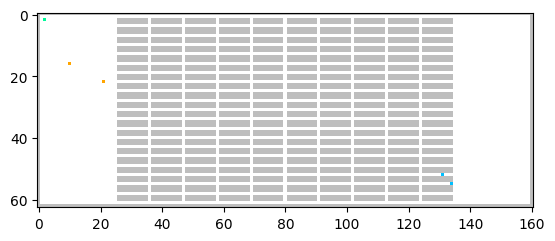

2024-06-11 15:05:34,590 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:05:40,477 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current position (131,10) and my destination (21,40), I see that I need to move west (to decrease my x-coordinate) and north (to increase my y-coordinate). However, my path to the north is blocked by a wall. The same goes for the south. I came from the east, and I can't go back, but there is a path to the west, so that seems to be my best option for now.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:05:43,899 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering that my current position is (134,7) and I have to get to (10,46), I need to move in the west direction to decrease my x-coordinate and in the north direction to increase my y-coordinate. However, my path to the north is blocked by a wall. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current coordinates are the same as my destination, I don't need to move.

Final Answer: Stay.

> Finished chain.


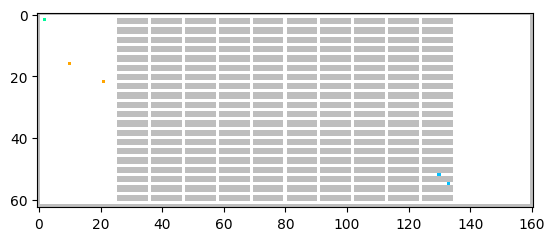

2024-06-11 15:05:46,426 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:05:51,351 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and destination, the most logical movement would be towards the west as it brings me closer to my destination. Since there are paths to the east and west, but walls to the north and south, my only options are to move east or west or stay. However, since my destination (21,40) has a lower x-coordinate than my current position (130,10), moving west will bring me closer to my target. 

Final Answer: West.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:05:55,845 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position at (133,7) and my destination at (10,46), it's clear that I need to move towards the west to decrease my x-coordinate and towards the north to increase my y-coordinate. Since both directions are open for me to move, I should prioritize moving towards the west as the difference in the x-coordinates is greater than the y-coordinates. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I am already at my destination, there is no need for me to move in any direction.

Final Answer: Stay

> Finished chain.


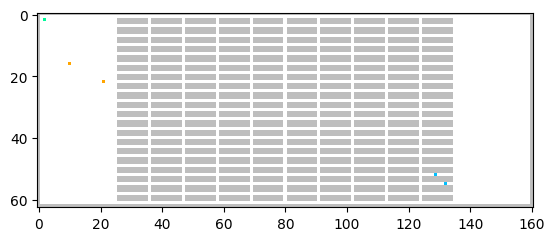

2024-06-11 15:05:59,286 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:06:03,745 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location is (129,10) and the destination is (21,40), I need to move towards the west to decrease the x-coordinate and towards the north to increase the y-coordinate. However, my north is blocked by a wall, and I just came from the east. Thus, the best option for me at the moment is to move west to start reducing the x-coordinate.
Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:06:06,989 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my destination is at (10,46) and I am currently at (132,7), I need to move west to reduce the x coordinate. Additionally, my north and south are blocked by walls, hence moving west is the only viable option.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I am already at the destination coordinates (2,60), there is no need for me to move in any particular direction.

Final Answer: Stay

> Finished chain.


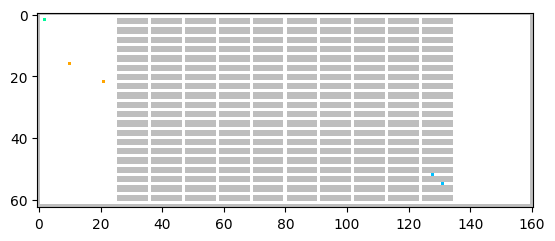

2024-06-11 15:06:10,986 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:06:14,713 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position and the destination, I need to move towards the west as my destination lies to the west of my current position. Also, considering my surroundings, I can only move east or west as the paths to the north and south are blocked by walls. Since I've just come from the east, my best option would be to continue moving west.

Final Answer: West.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:06:20,467 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current coordinates are (131,7) and I need to reach (10,46), it is clear that I need to move west to decrease the X coordinate and north to increase the Y coordinate. However, my current position is blocked by a wall on both the south and north. Given that I came from the east and I can't go back, my only viable option is to move west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering that my current coordinates are the same as my destination coordinates, I don't need to move in any direction.

Final Answer: Stay.

> Finished chain.


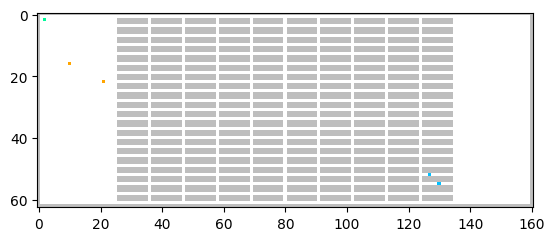

2024-06-11 15:06:23,298 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:06:27,178 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given that my current coordinates are (127,10) and my destination is (21,40), I need to move west to decrease my 'x' coordinate and north to increase my 'y' coordinate. However, my north is blocked by a wall. Therefore, my only option to make progress towards my destination is to move west. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:06:32,813 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position at (130,7) and my destination at (10,46), I need to move towards the west to decrease my x coordinate and towards the north to increase my y coordinate. However, my north and south are blocked, so my next move should be towards the west as there is a path in that direction.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I am already at my destination, there is no need to move. 

Final Answer: Stay.

> Finished chain.


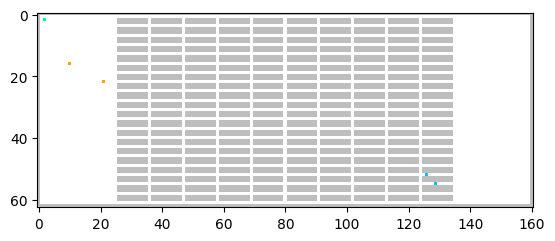

2024-06-11 15:06:35,122 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:06:39,296 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current position (126,10) and my destination (21,40), I realize that I need to move west to decrease my x-coordinate and north to increase my y-coordinate. However, the path to the north is blocked by a wall. Therefore, the best step for now would be to move west along the path.

Final Answer: West.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:06:43,778 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given that my current position is (129,7) and I need to reach (10,46), I have to move towards the west and north. However, my current position is blocked by a wall to the north and south. Therefore, the best direction to move at the moment, considering that I came from the east, would be to head west. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
I am already at the destination point (2,60). There is no need for me to move in any direction.

Final Answer: Stay.

> Finished chain.


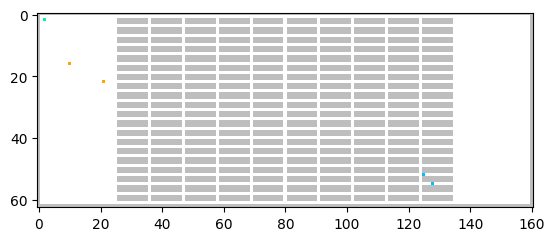

2024-06-11 15:06:47,660 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:06:50,914 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position (125,10), I need to get to the coordinates (21,40). However, my options are currently limited. I cannot go south or north because there are walls in both directions. Since I came from the east, the quickest route would be to backtrack west. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:06:57,116 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position at (128,7) and my destination at (10,46), I need to move towards the west to reduce my x-coordinate and towards the north to increase my y-coordinate. However, my movement to the north is currently blocked by a wall. Since I can only move east, west, south, or stay, and my south is also blocked, my best option is to move west which is open and also aligns with my goal to reach the destination.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current location and destination are the same, there is no need to move in any direction. 

Final Answer: Stay.

> Finished chain.


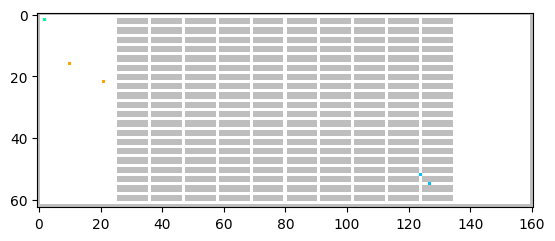

2024-06-11 15:06:59,838 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:07:05,421 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


To reach my destination from my current location (124,10) to (21,40), I need to move west to decrease my x-coordinate and north to increase my y-coordinate. However, since I can only make one move at a time, I need to prioritize one direction first. Since the difference in the x-coordinate is greater than the y-coordinate, I should prioritize moving west. Therefore, my next move should be west. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:07:10,237 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering that my current location is (127,7) and my destination is (10,46), I need to move towards the west and north. However, since my north is blocked by a wall and I came from the east, the best direction to move next would be west as it is the only logical option available that could potentially lead me towards my destination.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I am already at my destination, there is no need for me to move. 

Final Answer: Stay.

> Finished chain.


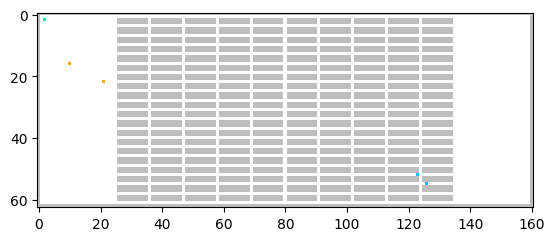

2024-06-11 15:07:13,309 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:07:16,542 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current location and the destination, I need to move west and north. However, the north is currently blocked, and I came from the east, so the best move right now would be to head west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:07:22,731 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and the destination, I need to move west to decrease the x coordinate value from 126 to 10. However, I also need to move north to increase the y coordinate value from 7 to 46. Currently, the paths to the east and west are open, but the paths to the north and south are blocked. Since I just came from the east, I should move west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
I am already at the destination coordinates, therefore, I don't need to move. 

Final Answer: Stay.

> Finished chain.


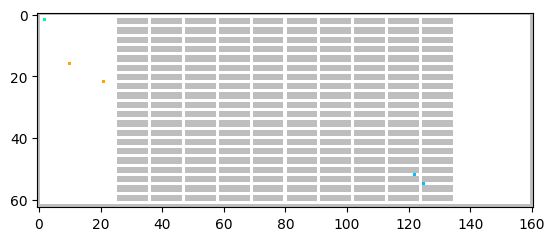

2024-06-11 15:07:25,131 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:07:32,105 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location is (122,10) and my destination is (21,40), and the only available paths are to the east and west, I must choose between these two directions. Given that the x-axis represents east-west movement and I am currently at a higher x-coordinate than my destination, my best course of action is to move west. Additionally, since I came from the east, it is logical to continue in the opposite direction, towards the west, to make progress towards my goal.

Final Answer: West.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:07:38,330 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since I am currently at (125,7) and my destination is (10,46), I must move towards the west to decrease my x-coordinate and get closer to my destination. Although my y-coordinate is also less than the destination's y-coordinate, my north is blocked by a wall. Thus, the only viable option I have is to move west as east will take me further away from my destination and south is also blocked by a wall.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current coordinates match my destination coordinates, there is no need for me to move in any direction.

Final Answer: Stay.

> Finished chain.


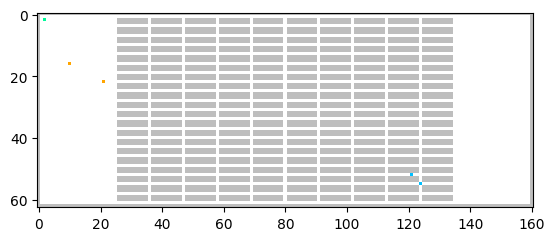

2024-06-11 15:07:41,881 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:07:46,767 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position at (121,10) and my destination at (21,40), and taking into account that I can only move east or west as both my north and south are blocked by walls, I have to choose the direction that will get me closer to my destination. Given that I am currently further to the east than my destination, my next move should be towards the west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:07:51,515 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering that I am currently at coordinates (124,7) and I need to reach (10,46), it's clear that I need to move west to decrease my x coordinate and north to increase my y coordinate. As I came from east, there might be a risk of backtracking if I move west. However, since all directions have a path and there are no obstructions mentioned, I should prioritize moving towards the target coordinates.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current location is the same as my destination, I don't need to move. 

Final Answer: Stay

> Finished chain.


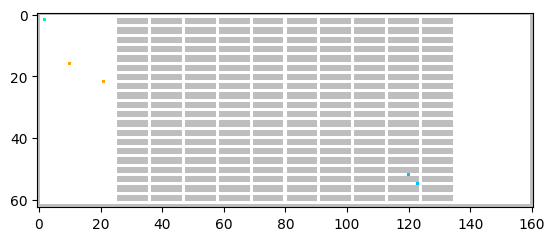

2024-06-11 15:07:54,415 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:07:59,510 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current coordinates are (120,10) and my destination is (21,40), I need to move west to decrease my x-coordinate and north to increase my y-coordinate. Since both south and north are blocked by walls, my only options are to move east or west or stay. Given that I came from the east and my destination is towards the west, the most logical direction would be to move west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:08:04,528 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and the location of the destination, I need to move in the direction that decreases my x-coordinate and increases my y-coordinate. However, my path to the south and north are blocked by walls. Since I came from the east, I should move west to change my position and hopefully find a path that leads north towards the destination.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current coordinates are the same as my destination coordinates, I am already at my destination. Therefore, I don't need to move in any direction.

Final Answer: Stay.

> Finished chain.


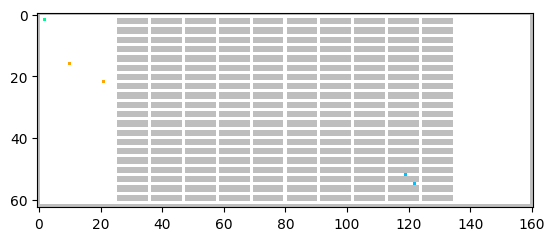

2024-06-11 15:08:07,447 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:08:13,244 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and destination, I should move west to get closer to the destination. However, I also need to keep in mind that I need to move north as well, but currently, the path to the north is blocked. Since I can only make one move at a time and my south and north are blocked, and I came from east, the best option for me right now is to move west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:08:17,391 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current coordinates and the destination, I need to move towards the west as the x-coordinate of the destination is smaller than my current x-coordinate. Also, since I cannot move either north or south due to the walls and east would take me further from the destination, west is the most logical choice. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I am already at my destination, there is no need to move in any direction. 

Final Answer: Stay.

> Finished chain.


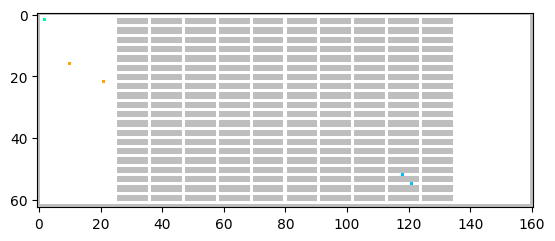

2024-06-11 15:08:20,014 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:08:24,248 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current coordinates (118,10) and my destination (21,40), I need to move west to decrease my x coordinate and closer to my destination. Also, since my south and north are blocked by a wall and I came from east, then the only feasible direction is west. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:08:28,348 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and the destination, I need to move towards the west as it's the direction that brings me closer to the target. Going east would take me further away, and both the north and south are blocked by walls. Therefore, the logical direction is west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current location is the same as my destination, there is no need for me to move.

Final Answer: Stay.

> Finished chain.


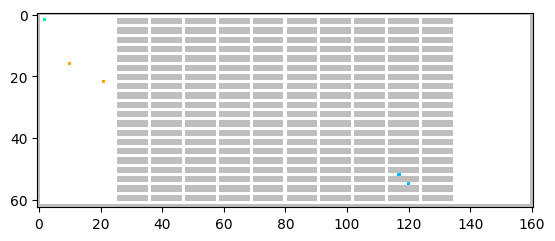

2024-06-11 15:08:30,966 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:08:36,270 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and the destination, I need to move towards the west as it decreases the x-axis value and gets me closer to my target. Both my north and south are blocked, and moving east would take me further away from the destination. So, west is the best option.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:08:39,850 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current position (120,7), it is clear that I am further east than my destination (10,46). So, I need to move west. However, my north and south are blocked, so I can only move east or west. Since I came from the east, I should continue moving west to reach my destination.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current coordinates are the same as my destination coordinates, I don't need to move. 

Final Answer: Stay

> Finished chain.


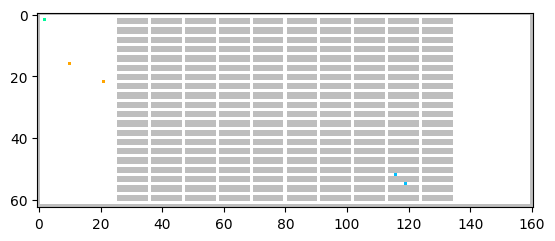

2024-06-11 15:08:42,336 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:08:48,880 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (116,10) and my destination (21,40), I need to move west to decrease my x-coordinate and then north to increase my y-coordinate. However, my north is blocked by a wall right now. My south is also blocked by a wall. That leaves me with east and west as possible directions. Given that I need to move west to approach my destination, my decision should be to move west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:08:52,506 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and my destination, I must move towards the west to reach my goal. However, I need to avoid crashing into the wall to the south or the north. Given that my path to the east and west is clear and I came from the east, the best move would be to go west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current coordinates are the same as my destination, there's no need for me to move.

Final Answer: Stay.

> Finished chain.


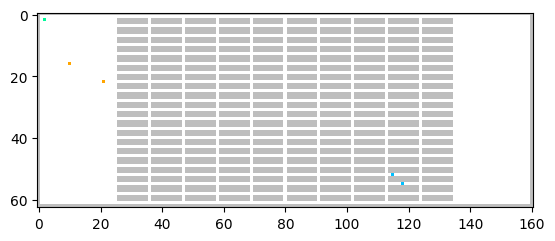

2024-06-11 15:08:55,087 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:09:01,262 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position is (115,10) and I need to reach (21,40), I am currently further east and south than my destination. However, since the path south and north are blocked, I cannot move in those directions. I came from east, so if I move east, I would be moving away from my destination. Therefore, the logical direction for me to move next would be west, as that moves me closer to my target x-coordinate.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:09:05,242 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and the destination, I need to move west to decrease the x-coordinate from 118 to 10. However, I must also consider the path that leads towards the destination. Since I came from the east and my south and north are blocked by a wall, my only option is to move west, as there lies a path.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current location is the same as my destination, there is no need to move.

Final Answer: Stay.

> Finished chain.


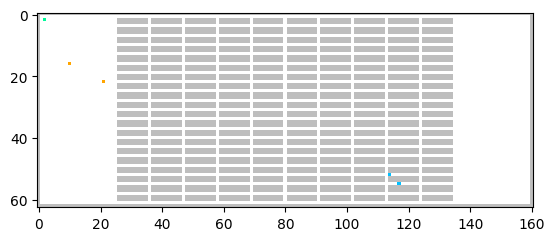

2024-06-11 15:09:07,582 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:09:11,409 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position is (114,10) and the destination is (21,40), it seems I need to move west and north. Given that my south and north are blocked by a wall, the only logical move would be to continue west as I came from east and there's a path available in that direction. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:09:14,347 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current position, the end goal, and the obstacles surrounding me, the best move would be to go west as it is a clear path and also it brings me closer to my destination.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I'm already at my destination, there's no need for me to move.

Final Answer: Stay.

> Finished chain.


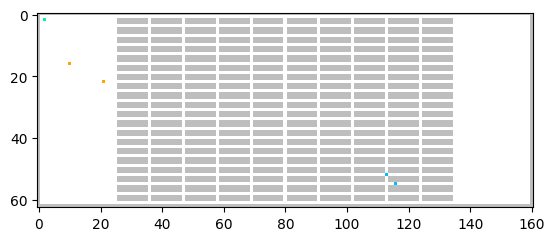

2024-06-11 15:09:17,461 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:09:23,125 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current location (113,10) and my destination (21,40), I am currently situated more towards the east and south of my destination. Since I can only move one point at a time and cannot crash into walls, I need to plan my path carefully. I came from the east, so I can either go west, north, south, or stay. I need to go more towards the west and north to reach my destination. So, I can either move west or north. Considering the immediate requirement to cover more distance on the x-axis (east-west), I should first move towards the west.

Final Answer: West.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:09:29,648 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location is (116,7) and my destination is (10,46), I need to move towards the west and north. Given the current scenario, although I need to move north, it is blocked by a wall. So, the next logical step would be to move west which is not blocked.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I am already at my destination, there is no need to move.

Final Answer: Stay.

> Finished chain.


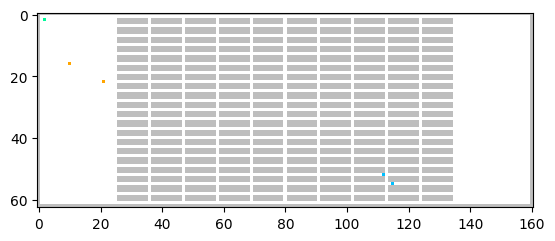

2024-06-11 15:09:31,941 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:09:36,598 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current coordinates, I can see that I am at a greater x-value than my destination. Since I can only move east or west and the y-axis is currently blocked, I will need to move towards the lower x-value to approach my destination. I also note that I came from the east, so going back in the direction I came from will move me closer to my destination.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:09:41,364 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and the destination, I need to move west to get closer to the x-coordinate of my destination. But my current position is closer to the y-coordinate of the destination. Since there is a path to the east and to the west, and I came from the east, I should move west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current location is the same as my destination, I don't need to move.

Final Answer: Stay.

> Finished chain.


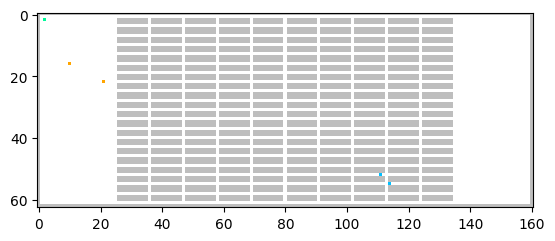

2024-06-11 15:09:43,428 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-11 15:09:48,494 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current position and destination, I need to move west to decrease my x-coordinate and move north to increase my y-coordinate. However, my north is blocked by a wall. Since I came from the east and there is a path to the west, I should move west to start making progress towards my destination.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-11 15:09:52,520 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my destination is at (10,46) and I'm currently at (114,7), I need to move towards the west to decrease my x-coordinate. My path to the south and north is blocked, and I just came from the east. Therefore, the best move would be to head west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current coordinates are the same as my destination, I don't need to move. 

Final Answer: Stay.

> Finished chain.


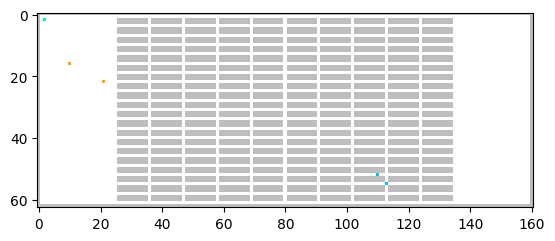

2024-06-11 15:09:55,084 - 19752 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


KeyboardInterrupt: 

In [7]:
# 1 turn
for n in range(100):

  step = [0 for i in range(num_agents)]

  #각 에이전트들의 시야에 있는 자신과 다른 에이전트들
  FOV_agents = []
  for i in range(num_agents):
    if np.any(env.observe()[0][i][0][2:7, 2:7]):
      non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
      non_zero_elements = [element - 1 for element in non_zero_elements]
      non_zero_elements.append(i)
      FOV_agents.append(non_zero_elements)

  #알고리즘을 이용해 연결된 집합 찾기
  connected_set = merge_sets(FOV_agents)

  #연결이 있는 모든 에이전트들
  deadlocked_agents = [item for sublist in connected_set for item in sublist]

  for i in range(num_agents):

    #교착상태에 빠지지 않은 에이전트는 독립적으로 navigate
    if i not in deadlocked_agents:
      
      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
      elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
      elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
      elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
      elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      action_list[i].append(result)
    
      step[i] = directiondict[result]

  
  #여기에 교착상태에 빠진 에이전트들을 계획.




  env.step(step)
  env.render()

### 교착상태 실험(잘 되면 위 코드로 넣기)

In [7]:
FOV_agents = []
for i in range(num_agents):
  if np.any(env.observe()[0][i][0][2:7, 2:7]):
    non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
    non_zero_elements = [element - 1 for element in non_zero_elements]
    non_zero_elements.append(i)
    FOV_agents.append(non_zero_elements)

connected_set = merge_sets(FOV_agents)
deadlocked_agents = [item for sublist in connected_set for item in sublist]

In [8]:
crew_tasks = []
crew_agents = []

for i in connected_set[0]:
    
    a_obs = env.observe()[0][i][1]
    x = env.observe()[1][i][1]
    y = map_width-env.observe()[1][i][0]
    x_finish = toy[2][i][1]
    y_finish = map_width-toy[2][i][0]

    if a_obs[4][3] == 0:
        west = """To your west lies a path."""
    else:
        west = """Your west is blocked by a wall."""

    if a_obs[4][5] == 0:
        east = """To your east lies a path."""
    else:
        east = """Your east is blocked by a wall."""

    if a_obs[5][4] == 0:
        south = """To your south lies a path."""
    else:
        south = """Your south is blocked by a wall."""

    if a_obs[3][4] == 0:
        north = """To your north lies a path."""
    else:
        north = """Your north is blocked by a wall."""

    if len(action_list[i]) == 0:
        last_action = """"""
    elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
    elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
    elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
    elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
    elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
    else:
        last_action = """"""

    crew_tasks.append(tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action))
    crew_agents.append(agents_set[i])

In [9]:
crew_tasks.append(tasks.negotiate(negotiator))
crew_agents.append(negotiator)

crew = Crew(
    agents=crew_agents,
    tasks=crew_tasks,
    verbose=0,
)

result = crew.kickoff()

2024-06-07 20:55:54,863 - 30180 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...
Given my current location at (1,2) and my destination at (4,2), as a path finder, logically I should move towards the direction that gets me closer to the destination. In this case, the direction is towards the east as it increases the x-coordinate, bringing me closer to the destination. 

Thought: I am currently at coordinates (1,2) and I need to get to (4,2). The x-axis corresponds to the east-west direction while the y-axis corresponds to the north-south direction. Therefore, I should move east to increase my x-coordinate and get closer to the destination.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given that my current position is (3,2) and the destination is at (0,2), it is clear that we need to move in a direction that decreases our x-coordinate without changing the y-coordinate. This is because we are currently aligned with the destination on the y-axis, but we are to the east of it on the x-axis